# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

## 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
# Jedi Not Working
#  %config Completer.use_jedi = False
! pip install ./python
! pip install toml
! pip install requests
! pip freeze > requirements.txt

Processing /home/workspace/python
    100% |████████████████████████████████| 48.1MB 966kB/s eta 0:00:01
    100% |████████████████████████████████| 6.4MB 5.4MB/s eta 0:00:01
    100% |████████████████████████████████| 8.8MB 5.2MB/s eta 0:00:01
    100% |████████████████████████████████| 133kB 27.5MB/s ta 0:00:01
    100% |████████████████████████████████| 3.1MB 16.1MB/s ta 0:00:01
    100% |████████████████████████████████| 122kB 25.0MB/s ta 0:00:01
    100% |████████████████████████████████| 61kB 13.0MB/s ta 0:00:01
    100% |████████████████████████████████| 2.2MB 14.7MB/s ta 0:00:01
    100% |████████████████████████████████| 378kB 27.6MB/s ta 0:00:01
  Running setup.py bdist_wheel for unityagents ... done
  Stored in directory: /tmp/pip-ephem-wheel-cache-nau0aai9/wheels/97/7a/24/09937717b9737178ae827bcef33ba219b540efd55be210010c
  Running setup.py bdist_wheel for docopt ... done
  Stored in directory: /root/.cache/pip/wheels/9b/04/dd/7daf4150b6d9b12949298737de9431a324d4b797ffd63f5

In [2]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

*Author Note:* This project uses a custom environment manager that abstracts the UnityEnvironment such that an OpenAI Gym
environment and a Unity instance will have the same commands as seen by the Agent and Trainer objects.

## DDPG

### Project Architecture

The Architecture of this project was extended from the model architecture used 
in project 1. Primarily, I built an environment manager API such that the minor
differences between OpenGym AI environments and Unity Environments can be
abstracted from the Trainer and Agent models such that either environment can
be used to train an agent with minimal to no change in code.

This leads to the discussion of the three primary classes within this project.
the `EnvironmentMgr`, the `Trainer`, and the `Agent` interfaces.

1. `EnvironmentMgr` - Each `EnvironmentMgr` class contains common commands the
   `Trainer` can interface with to command the environment to `start`, `step`,
   `reset`, `get_evn`, and `close`.
   
2. `Trainer` - This class is intended to hold all of the properties for the
   experiment and manipulate both the `Agent` and the `Environment`.
   
3. `Agent` - This is the class that holds the reinforcement learning agent and
   maintains a similar structure to other implementations with minor edits for
   function encapsulation.

#### Agent Selection

Due to the difficulty of the problem and the amount of implementations using
Deep Deterministic Policy Gradient (DDPG), I chose to implement a similar
version, in order to leverage and compare my code with the available 
resources - and solicit feedback for others to review my code.

Using the DDPG implementation from the Bipedal and Pendulum models as starting
points I implemented my version of the DDPG agent. I implemented the 
Ornstein-Uhlenbeck process to add noise to my model similar to the example, and
following the advice of the prompt - I implemented methods to restrict learning
for the target Actor and Critic models as well as implementing a way to 
randomly sample a subset of agents (if n>1) for learning.

#### DDPG

DDPG originally proposed in the 
[2016 Google Deepmind Paper](https://arxiv.org/pdf/1509.02971.pdf)
proposes a DPG method applying Q-learning. The architecture consists of two 
deep networks, an Actor and a Critic. The Actor determines the action provided
the environment state. The Critic rates the Actor's action as good or bad 
provided the state and the actor's action. Both the actor and critic maintain
two networks each as a local and a target network. Where the best action is
selected from the target action and the local network learns from the response.
Over the course of training the target network will be updated using a 
`soft_update` algorithm where a parameter $\tau$ dictates the percent weight of
the local network to update to the target network.

#### Neural Network Model Architecture

After reviewing several times with fellow students and discussing with mentors
within the forums. I've selected an `Actor` Model consisting of `3` fully 
connected layers with hidden layers of `256` and `128` units wide and input
units equal to the state size and output units equal to the action size. For
the `Critic` Model, I've constructed a `3` fully connected model again with
hidden layers equal to `256` and `128` units wide, but following the 
recommendation of Agents of this structure to inject the states as inputs into
the first layer and actions into the second. Finally, outputting a single node.

Similar to the [Original DDPG paper](https://arxiv.org/pdf/1509.02971.pdf), 
similar deep architectures were constructed for the Actor and Critic. For 
activation functions, the `ReLU` function was used for the `Actor` to 
minimize complexity and the hyperbolic tangent function (`tanh`) was used as
output for the `Actor`. The tanh function provides a continuous space 
between action bounds for the actor to select from. The `Critic` maintains a
similar architecture to the architecture provided in the paper where the 
environment state is passed into a fully connected (FC) layer and the following
hidden layer ingests the output of that FC layer plus the action of the Actor.
The output of the Critic is simply a single node used to determine if the 
action was good or bad.

Weights were initialized using uniform distribution from 
$\mp\frac{1}{\sqrt{N_{input}}}$ for all of the nodes save for the final node
where a uniform distribution between $\mp3e-3$ was established.

### Hyperparameter Optimization

This section investigates hyperparameters  the `Actor` and `Critic` models, the `Agent` and `Trainer` architectures.

#### Learning Rates

Conducting a grid search with learning rate for actor and critic I the 
following relations running 50 episode epochs:
```
Actor LR: 1.0e-04	Critic LR: 1.0e-04
Episode 50	Average Score: 0.87

Actor LR: 1.0e-04	Critic LR: 1.0e-03
Episode 50	Average Score: 0.47

Actor LR: 1.0e-04	Critic LR: 2.0e-03
Episode 50	Average Score: 0.36

Actor LR: 1.0e-03	Critic LR: 1.0e-04
Episode 50	Average Score: 0.86

Actor LR: 1.0e-03	Critic LR: 1.0e-03
Episode 50	Average Score: 0.86

Actor LR: 1.0e-03	Critic LR: 2.0e-03
Episode 50	Average Score: 0.04

Actor LR: 2.0e-03	Critic LR: 1.0e-04
Episode 50	Average Score: 0.85

Actor LR: 2.0e-03	Critic LR: 1.0e-03
Episode 50	Average Score: 0.04

Actor LR: 2.0e-03	Critic LR: 2.0e-03
Episode 50	Average Score: 0.65
```

There seems to be a few promising learning rates between the actor and critic
I have found success with Actor / Critic LRs and have decided to keep the learning
rates equal to `1e-4`.

#### Learning Period (frequency of soft-update to target network)

When investigating learning period for soft updating the following was 
observed:
```
Actor LR: 2.0e-03	Critic LR: 1.0e-04	L_Period: 1
Episode 50	Average Score: 0.86

Actor LR: 2.0e-03	Critic LR: 1.0e-04	L_Period: 5
Episode 50	Average Score: 0.77

Actor LR: 2.0e-03	Critic LR: 1.0e-04	L_Period: 10
Episode 50	Average Score: 0.44

Actor LR: 2.0e-03	Critic LR: 1.0e-04	L_Period: 15
Episode 50	Average Score: 0.66

Actor LR: 2.0e-03	Critic LR: 1.0e-04	L_Period: 20
Episode 50	Average Score: 0.66
```

The fastest learning rate was inversely proportional to the period. Keeping
in mind that I likely will need to maintain a period of `20` time steps taking
into account previous advice from Udacity

#### Buffer and Batch Sizing

Buffer size appear to have significant impacts, especially with networks 
training for very long times. The below figure depicts the mean scores of
the last 100 episodes of a Agent with:
```Python
BUFFER_SIZE =1e5
ACTOR_LR    = 1e-4
CRITIC_LR   = 1e-3
LEARN_F     = 20
```

![Buffer Size Failure](ddpg-forgetting.png)

I reviewed this with a mentor, Amita, and provided some literature capturing
this event as [catastrophic inference](https://www.sciencedirect.com/science/article/abs/pii/S0079742108605368?via%3Dihub).
Since then, I have increased my buffer size to `1e6`.

I've reviewed several others student's projects and and found a wide range of batch sizing.
I have noticed that larger batch sizes result in a hysteresis in learning for early time
steps. As such, I determined to use a smaller batch size to reduce training times on the
GPU resources available to us through Udacity's virtual environment.


#### Noise

The original paper and the Udacity advice mentions the advantage of injecting Gaussian or
Ornstein–Uhlenbeck noise into the actions of the Actor in order to encourage the Agent to
explore off-policy and generate a more stable network. However, I found in my initial
experiments that the OU Noise was preventing my Agent to achieve a score of greater than 
~28. As such, I experimented with turning off the noise and was able to achieve the required
agent score and have left the noise out of the final solution. However, the wisdom of
including noise into an agent such as DDPG is sound and tuning the noise parameters may
be a wiser course of action when applying a similar agent to more complex scenarios.

### Primary Import and Utility Functionality

In [ ]:
# %config Completer.use_jedi = True
!pip -q install toml
!pip -q install ../python
!pip -q install requests

import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from reacher_agents.ddpg_agent import DDPGAgent
from reacher_agents.trainers import MultiAgentTrainer, SingleAgentTrainer


### Hyper Parameters

Reviewing implementations from other students as well reviewing comments from
the Mentor Advice board - I've constructed the following Hyper Parameters for
the run for record.

In [3]:
%%writefile reacher_agents/config.py

ENV_TYPE = 'unity'        # enum ('unity', 'gym') = choose which environment to run
CLOUD = True              # True if running in Udacity venv
BUFFER_SIZE = int(1e6)    # Replay buffer size
BATCH_SIZE = 16           # minibatch size
N_EPISODES = 1000         # max number of episodes to run
MAX_T = 1000              # Max time steps within an episode
N_WORKERS = 20            # number of workers to run in environment
MAX_WORKERS = 10          # number of workers to learn from an episode, ignored if N_WORKERS < MAX_WORKERS
LEARN_F = 20              # Learning Frequency within episodes
GAMMA = 0.99              # discount factor
TAU = 1e-3                # soft update target parameter
LR_ACTOR = 1e-4           # learning rate for the actor
LR_CRITIC = 1e-4          # learning rate for the critic
WEIGHT_DECAY = 0.         #0.0001 - L2 weight decay parameter
WINDOW_LEN = 100          # window length for averaging
ACTOR_UNITS = (256, 128)  # Actor Hidden architecture s -> h1 -> ... -> hn -> a
CRITIC_UNITS = (256, 128) # Critic s -> h1+a -> ... -> hn -> 1
ADD_NOISE = False         # Add OU noise to the agent's action
SAVE_ALL = True           # Save meta data from trainer as a pickle file`



In [14]:
# %%writefile main.py  # uncomment to write to main.py

import matplotlib.pyplot as plt
import seaborn as sns

from reacher_agents.gym_environments import GymContinuousEnvMgr
from reacher_agents.unity_environments import UnityEnvMgr
from reacher_agents.trainers import SingleAgentTrainer, MultiAgentTrainer
from reacher_agents.config import *  # Unnecessary for notebook - but useful for main run
from reacher_agents.ddpg_agent import DDPGAgent


def main():
    if ENV_TYPE.lower() == 'gym':
        envh = GymContinuousEnvMgr('Pendulum-v0')
        root_name = 'gym'
        Trainer = SingleAgentTrainer
        upper_bound = 2.0
        solved = -250
        env = envh.start()
        state_size = envh.state_size
        action_size = envh.action_size
    else:
        root_name = 'unity'
        if N_WORKERS == 1:
            file_name = 'envs/Reacher_Windows_x86_64-one-agent/Reacher.exe'
        else:
            file_name = 'envs/Reacher_Windows_x86_64-twenty-agents/Reacher.exe'
        envh = UnityEnvMgr(file_name)
        Trainer = MultiAgentTrainer
        upper_bound = 1.0
        solved = 30.0
        state_size = 33
        action_size = 4

    if CLOUD:
        if N_WORKERS==1:
            file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64'
        else:
            file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64'
        envh = UnityEnvMgr(file_name)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # device = torch.device("cpu")
    agent = DDPGAgent(
        state_size=state_size,
        action_size=action_size,
        buffer_size=BUFFER_SIZE,
        batch_size=BATCH_SIZE,
        gamma=GAMMA,
        tau=TAU,
        lr_actor=LR_ACTOR,
        lr_critic=LR_CRITIC,
        learn_f=LEARN_F,
        weight_decay=WEIGHT_DECAY,
        device=device,
        random_seed=42,
        upper_bound=upper_bound,
        actor_hidden=ACTOR_HIDDEN,
        critic_hidden=CRITIC_HIDDEN,
        add_noise=ADD_NOISE
    )
    trainer = Trainer(
        agent=agent,
        env=envh,
        n_episodes=N_EPISODES,
        max_t=MAX_T,
        window_len=WINDOW_LEN,
        solved=solved,
        n_workers=N_WORKERS,
        max_workers=MAX_WORKERS,  # note can be lower than n
        save_root=root_name,
    )
    return envh, agent, trainer

def plot_scores(scores, i_map=0):
    sns.set_style('darkgrid')
    sns.set_context('talk')
    sns.set_palette('Paired')
    cmap = sns.color_palette('Paired')

    scores = np.array(scores).squeeze()
    score_df = pd.DataFrame({'scores': scores})
    score_df = score_df.assign(mean=lambda df: df.rolling(10).mean()['scores'])

    fig ,ax = plt.subplots(1,1, figsize=(10,8))

    ax = score_df.plot(ax=ax, color=cmap[2*(i_map%4):])
    ax.set_title(f'DDPG Scores vs Time (LR=({LR_ACTOR:.1e}, {LR_CRITIC:.1e}), Lf={LEARN_F})')
    ax.set_xlabel('Episode #')
    ax.set_ylabel('Score')
    plt.show()


# # Uncomment this when exporting if you would like to run from the terminal
# if __name__ == '__main__':
#     _, _, trainer = main()
#     scores = trainer.train(save_all=True, is_cloud=CLOUD)
#     plot_scores(scores)

### Run

In [5]:
envh, agent, trainer = main()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [6]:
trainer.agent.device

device(type='cuda', index=0)

In [7]:
agent.actor_local

DDPGActor(
  (fc1): Linear(in_features=33, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)

In [8]:
agent.critic_local

DDPGCritic(
  (fc1): Linear(in_features=33, out_features=256, bias=True)
  (fc2): Linear(in_features=260, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)

In [9]:
scores = trainer.train(save_all=True, is_cloud=CLOUD)

Episode 10	Average Score (episode): 1.00 	Max Score (episode): 2.54 	Average Score (deque): 0.83
Episode 20	Average Score (episode): 3.23 	Max Score (episode): 7.52 	Average Score (deque): 1.55
Episode 30	Average Score (episode): 6.20 	Max Score (episode): 9.50 	Average Score (deque): 2.639
Episode 40	Average Score (episode): 10.60 	Max Score (episode): 23.24 	Average Score (deque): 4.02
Episode 50	Average Score (episode): 24.35 	Max Score (episode): 30.19 	Average Score (deque): 6.67
Episode 60	Average Score (episode): 31.05 	Max Score (episode): 38.82 	Average Score (deque): 10.31
Episode 70	Average Score (episode): 39.13 	Max Score (episode): 39.62 	Average Score (deque): 14.09
Episode 80	Average Score (episode): 38.99 	Max Score (episode): 39.65 	Average Score (deque): 17.19
Episode 90	Average Score (episode): 39.29 	Max Score (episode): 39.61 	Average Score (deque): 19.63
Episode 100	Average Score (episode): 38.02 	Max Score (episode): 39.56 	Average Score (deque): 21.51
Episode 1

### Visualize

Visualize the scores of the trained agent. 

* The `i_map` parameter to rotate through the seaborn color palette (paired in 
  groups of 2)
  * 0: blue
  * 1: green
  * 2: red
  * 3: orange
  * 4: purple


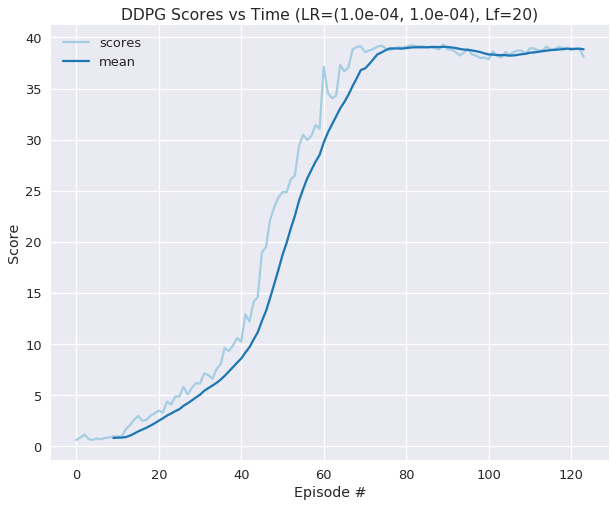

In [15]:
plot_scores(scores)

In [16]:
trainer.save_scores('unity-solved-scores.pkl')

## Results

Using the tuned hyper parameters the DDPG implementation was able achieve a score of `>30.0`
in `124` episodes with `20` agents.

## Future Work

The final agent does not inject noise into the system which may leave the agent
unstable. Tuning the noise hyper parameters to allow for this feature would be
a sound next step. Additionally, applying different Agents such as alternate 
Actor/Critic models such as Twin Delayed DDPG (TD3) may show improved performance 
over the applied DDPG application. DDPG is an off-policy method and as such, does 
not explore actions with a policy that is learning. Another avenue to explore would
be to investigate an on-policy methods such as Asynchronous Actor Critic (A3C)
to evaluate performance directly.